# SOM
### Juan Camilo Cática

### Diego Escobar

### Ricardo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Clases desarrolladas 

Estas clases fueron desarrolladas con la finalidad de implementar el algorimo SOM y entender el funcinamiento real del algoritmo.



### SOM2D

In [17]:
import numpy as np
import pandas as pd
import math
from mytimer import my_timer
from sklearn.base import BaseEstimator, TransformerMixin

class SOM2D(BaseEstimator, TransformerMixin):
    """
    Esta clase implementa un SOM (Self-Organizing Map) a partir de las dimensiones establecidas
    desde el método constructor.

    Este método inicializa algunos de los atributos implementados por el algoritmo a través de 
    los parametros de entrada. Sin embargo, algunos de estos son definidos tras el entrenamiento del 
    algotimo.

    La red neuronal o mapa que se genera con la implementación de esta clase es, en terminos estrictos,
    una matriz con número de filas igual a 'hight' y número de columans igual a 'widht'.

    Parametros:
    -----------
        hight: int.
            Establece la alturna en número de unidades de la red neuronal (SOM), es decir, el número
            de filas de la matriz que simula la red.

        widht: int.
            Establece la anchura en número de unidades de la red neuronal (SOM), es decir, el número
            de columnas de la matriz que simula la red.

        alpha: float, default 0.2.
            Se define como la taza de apendizaje y olvido del algotirmo SOM. 

        distance: float, default 2.
            Es la distancia maxima a la cual se desarrollará la propagación de actualización
            de los pesos de las neuronas vecinas. Es análogo a la técnica 'spreading activation'.

        epochs: int, default 100.
            Número de epocas definidas para desarrollar el entrenamiento de estimador.

    Atributos:
    ----------
        self.proximity_matrix:
            Este atributo es una matriz cuadrada con dimensiónes laterales iguales al número de neuronas
            o unidades 'self._units' definidas  por el producto entre los parametros hight y widht.

            Esta matriz contine las distancias en terminos de la composición del mapa entre cada una 
            de las neuronas que compone la red. 

            Este atributo se inicializa al momento de compilar la red, es decir, cuando se ejecuta
            el método 'self.compile()'.  

        self.decay_values:
            Este atributo es un diccionario que contiene el valor de decaimiento para cada neruona que 
            se encuentre en el rango de proximidad de cada una de las neuronas de la red que puedan
            llegar a ser la neurona ganadora en cada iteración.

            self.decay_values:{
                neurona_ganadora0: [(neurona1, decay_val),(neurona2, decay_val),...,(neuronaN, decay_val)]
                neurona_ganadora1: [(neurona0, decay_val),(neurona2, decay_val),...,(neuronaM, decay_val)]
                ...
            }

            eje:
                self.decay_values:{
                    0:[(1,0.98), (2,0.95), ... (n, ##)]
                    1:[(0,0.98), (2,0.91), ... (m, ##)]
                    ...
                    k:[(0,0.83), (1,0.95), ... (l, ##)]
                }
                donde: n, m, l son el maximo de neuronas que entran en el radio de cobertura definido
                por 'distance' cuando la neurona ganadora en cada iteración reuslta ser 0, 1, ó k.

        self.mean_distances:
            Este atributo es un vector que almacena la distncia media de cada neurona con respecto a las
            demás en termino de los vectores de pesos.

            Este atributo se emplea para generar la gráfica tipo panal de abeja por medio del método
            'self.plot()' cuando el valor del parametro 'som_map' de dicho método es igual a "distance".

        self.label_matrix:
            Esta matriz se inicializa cuando se ha entrenado el estimador con etiqeutas de clase. Donde
            el número de filas representa el numero de neuronas y el número de coumnas las etiquetas de
            clase.

            Los valores contenidos en esta matriz son basicamente el número de registros que han sido 
            asociado a cada neurona. Estos valores pueden estar modificados en por efectos de la función
            de decaimiento.

        self.labels:
            Este atributo es una vector de etiquetas, el cual se obtiene a partir de la matriz 
            'self.label_matrix', Sabiendo que cada fila de la matriz 'self.label_matrix' representa una
            neurona, y los valores de las columnas representan las etiquetas, el valor de 'self.labels'
            se optiene a partir del valor maximo de cada columna para cada una de las filas (neuronas).

        self.W
            Este atributo es una matriz que representa los vectores de pesos de cada una de las
            neuronas de la red neuronal del  algorimo SOM. Esta matriz se inicializa al momento de 
            entrenar el modelo, es decir al momento de invocar el metodo 'self.fit()'.

        self.quantization_error: float
            Error de cuantificación sobre el conjunto de datos de entrenamiento.
            
        self.topological_error: float
            Error de cuantificación sobre el conjunto de datos de entrenamiento.

        IMPORTANTE:    
            Ejemplo de la Matriz de neuronas del Algoritmo SOM (Representación Matricial):
                    j
                  0,1,2
                i 3,4,5
                  6,7,8

            La matriz anterior es una representación reordenada t reformateada del vector de neuronas.
            La siguiente matriz es la matriz de priximidad (self.proximity_matrix) la cual contiene las 
            distancias en terminos del arreglo de la matriz de cada una de las neuronas en la representación
            matricial.
                       k1
                   0 1 2 3 4 5 
                   -----------
                0| 0 1 2 1 . . 
                1| 1 0 1 . 1 . 
            k2  2| 2 1 0 
                3| 1 .   0
                4| . 1     0
                5| . .       0    
    
    Desarrollado por:
        Juan Camilo Cática Buendía.
    """
    
    def __init__(self, hight, widht, alpha = 0.2, distance = 2, epochs = 100):
        # -------------------------------------------------
        # ATRIBUTOS DEFINIDOS POR LOS PARÁMETROS DE ENTRADA
        #
        self._widht = widht
        self._hight = hight
        self._alpha = alpha
        self._distance = distance
        self._epochs = epochs
        self._units = hight*widht
        
        # ---------------------------------------------------
        # ATRIBUTOS DE CONTROL DE ENTRENAMIENTO Y COMPILACIÓN
        #
        self._compiled = False
        self._trained = False
        self._labeled = False
        
        # ---------------------------------------------------------------
        # ATRIBUTOS QUE SE DEFINEN DURANTE LA COMPILACIÓN Y ENTRENAMIENTO
        #
        self.proximity_matrix = None
        self.decay_values = dict()
        self.mean_distances = []
        self.label_matrix = []
        self.labels = []
        self.W = None
        self.quantization_error = -1
        self.topological_error = -1
    
    def fit(self, X, y = None):
        """
        Método de entrenamiento.
        
        Este método se ejecuta en cuatro etapas, las cuales son:
            1.  ETAPA DE ACTUALIZACIÓN DE LOS PESOS DE LAS NEURONAS. 
                Esto se desarrolla bajo el algoritmo SOM.
                $ 𝒘_𝒋(𝑡 + 1) = 𝒘_𝒋(𝑡) + 𝛼 V(d(i,j),g)(𝒙_𝒊 − 𝒘_𝒋(𝑡)) $
                
            2.  GENERACIÓN DE DISTANCIAS MEDIAS ENTRE NEURONAS.
            
            
            3.  ETIQUETAS DE LAS NEURONAS.
            
            
            4.  CÁLCULO DEL ERROR DE CUANTIFICACION (QE: QUANTIFICATION ERROR).
            
        
        ADVERTENCIA: 
            Los datos de entrada por el vector 'y' deben estar codificados de 0 a n.
            Donde el valor de 'n' es el númeor de clases posibles.
            
        IMPORTANTE:
            Este método no se encuentra optimizado en términos de reutilización de código.
            En cada etapa se implementa código similar. (REVISAR POSIBILIDADES).
                   
        Parametro:
        ----------
        
            X: numpy.array
                Conjunto de datos sin etiquetas de clase.
            
            y: list or numpy.array, default None.
                Etiquetas de classe para cada uno de los registros de 'X'.
            
        """
        assert self._compiled, "No se ha compilado la red neuronal (SOM)."
        assert not self._trained, "La red ya fue entrenada"
        _, n_variables = X.shape
        self.W = np.random.randn(self._units, n_variables)
        self.W_old = self.W.copy()
        serie_i = pd.Series(range(len(X)))
        
        # ---------------------------------------------------
        # ETAPA DE ACTUALIZACIÓN DE LOS PESOS DE LAS NEURONAS
        #
        timer = my_timer(nombre="SOM Algo",total_iter=self._epochs)
        for epoch in range(self._epochs):
            for i in serie_i.sample(frac=1):
                nomrs = []
                for W_j in self.W:
                    nomrs.append(np.linalg.norm(X[i] - W_j))
                wn = np.argmin(nomrs)
                 
                for j, decay_val in self.decay_values[wn]:
                    self.W[j] = self._update(self.W[j], X[i], decay_val)
            timer.iter()
        timer.end()
        # ----------------------------------------------
        # GENERACIÓN DE DISTANCIAS MEDIAS ENTRE NEURONAS
        #
        for i in range(len(self.W)):
            distances = []
            for j in range(len(self.W)):
                distances.append(np.linalg.norm(self.W[i] - self.W[j]))
            self.mean_distances.append(np.mean(distances))
        
        # -------------------------
        # ETIQUETAS DE LAS NEURONAS
        #
        if y is not None:
            self.labels = pd.Series(y).unique()
            self.label_matrix = np.zeros((self._units, len(self.labels)))
            
            for xi, yi in zip(X,y):
                nomrs = []
                for W_j in self.W:
                    nomrs.append(np.linalg.norm(xi - W_j))
                wn = np.argmin(nomrs)

                for j, decay_val in self.decay_values[wn]:
                    self.label_matrix[j, yi] += decay_val 
            self._labeled = True
            
        # ------------------------------------------------------------
        # CÁLCULO DEL ERROR DE CUANTIFICACION (QE: QUANTIZATION ERROR)
        # CÁLCULO DEL ERROR TOPOLÓGICO (TE: TOPOLOGICAL ERROR)
        #
        q_error = 0
        t_error = 0
        for xi in X:
            nomrs = []
            for Wj in self.W:
                nomrs.append(np.linalg.norm(xi - Wj))
            wn1 = np.argmin(nomrs)
            q_error += nomrs[wn1]
            
            del nomrs[wn]
            wn2 = np.argmin(nomrs)
            t_error += 0 if self._adjacent(wn1,wn2) else 1
                  
        self.quantization_error = q_error / len(X)        
        self.topological_error = t_error / len(X)
        
        # ---------------------------------------------
        # ENTRENAMIENTO DESARROLLADO SATISFACTORIAMENTE
        #        
        self._trained = True
    
    def compile(self):
        """
        Este métod debe ser ejecutado antes de ejecutar el método 'self.fit()'.
        
        Este metodo inicializa la matriz de proximidad (self.proximity_matrix) se inicializa con valores de cero.
        Posteriormente calcula todos los valores de proximidad de entre las neuronas en terminos del arreglo 
        matricial.
        
        Finalmente, se asignan los valors de decamiento para cada una de las combinaciones de neuronas 
        (neurona genadora y neurona proxima), donde las neuronas proximas son seleccinadas a partir del rango
        definido por el parametro 'distance' del método constructor de cada una de las neuronas existentes.
        
        Los valores de decaimiento son almacenados por un diccionario. Para entender el formato del diccionario
        ver self.decay_values en el docstring del metodo constructor en la sección de atributos.
        
        IMPORTANTE: 
            Este metodo puede tardar de manera considerable en función de las neuronas que componen la red SOM.
        """
        self.proximity_matrix = np.zeros((self._units,self._units))
        for k1 in range(self._units):
            for k2 in range(k1):
                vect_k1 = self._coordinates_ij(k1)
                vect_k2 = self._coordinates_ij(k2)
                distance = np.linalg.norm(vect_k1 - vect_k2)
                self.proximity_matrix[k1,k2] = self.proximity_matrix[k2,k1] = distance
                
        for k1 in range(self._units):
            neurons_decays = []
            for k2 in range(self._units):
                proximity = self.proximity_matrix[k1,k2]
                if self._distance >= proximity:
                    neurons_decays.append((k2,self._decay_function(proximity))) 
            self.decay_values[k1] = neurons_decays
        self._compiled = True    
    
    
    def _coordinates_ij(self, k):
        """
        Este método permite obtener la cardinalidad de cada neurona bajo una representación matricial.
        Ya que esta clase implementa el conjunto de neuronas como un vector.
        
        Parametros:
        -----------
        
            k: int
                Posición de la neurona en el vector 'self.W'
            
        """
        i = k // self._widht
        j = k % self._widht
        return np.array([i,j])
    
    def _decay_function(self, dist):
        """
        La función de decaimiento.
        
        Parametro:
        ----------
        
            dist: float
                Distancia con la cual obtiene el valor de decaimiento.
        """
        return math.e**(-dist)
    
    def _update(self, W_j, x_i, decay_val):
        """
        Función para la actualización del peso de las neuronas, en esta se contempla el valor de decaimiento
        en el proceso de actualización.
        """
        return W_j + self._alpha * (decay_val * (x_i - W_j))
    
    def _adjacent(self, neuron1, neuron2, edge = 1):
        """
        Esta función permite determinar si las dos neuronas son adjacentes en nunción del valor del parametro
        'edge', el cual por defecto se encuentra en uno.
        """
        i1, j1 = self._coordinates_ij(neuron1)
        i2, j2 = self._coordinates_ij(neuron2)
        
        delta_i = abs(i2-i1)
        delta_j = abs(j2-j1)
        
        return delta_i <= edge and delta_j <= edge
    
    def plot(self, name = "", som_map = "distance", ticklabels = None, figsize=(7, 4), 
             distance_cmap = 'gray_r', labeled_cmap = None):
        """
        Metodo para plotear la gráfica de panal de abeja.
        
        Esta gráfica puede esta basada en un vector de distancias o en un vector de etiquetas de clase
        según el entrenamiento del estimador.
        
        parametros:
        -----------
        
            name: str
                Nombre de la gráfica.
                
            som_map: str
                Tipo de mapa a proyectar. 
                'distance': Mapa de distancias entre las neuronas
                'labeled' : MApa de coloración. Solo funcióna cuando se ha entrenado con etiquetas de clase.
            
            ticklabels: list, default None.
                Nombre de las etiquetas de clase
            
            figsize: tuple
                Tamaño de la figura.
            
            distance_cmap:
                cmap para la coloración del mapa cuando el valor de 'som_map' es igual a 'distance'.
            
            labeled_cmap:
                cmap para la coloración del mapa cuando el valor de 'som_map' es igual a 'labeled'.
        """
        assert self._compiled, "No se ha compilado la red neuronal (SOM) :("
        assert self._trained, "No se ha entrenado la red :("
        if ticklabels is not None and len(ticklabels)>1:
            assert len(self.labels)==len(ticklabels), "'ticklabels' no es de igual longitud que 'self.labels'"
            
        gridsize = max(self._widht,self._hight)
        x = []
        y = []
        if som_map == "distance":
            fig = plt.figure(figsize=figsize)
            for k_neuron in range(self._units):
                i,j = self._coordinates_ij(k_neuron)
                x.append(j)
                y.append(i)

            hb = plt.hexbin(x, y, C = self.mean_distances, gridsize = gridsize, cmap = distance_cmap)
            plt.title("Mean Distance")
            cb = fig.colorbar(hb)
            cb.set_label('Distance')

        elif som_map == "labeled":
            assert self._labeled, "No se especificaron etiquetas durante el entrenamiento"
            fig = plt.figure(figsize=figsize)
            label_neurons = []
            for k_neuron in range(self._units):
                i,j = self._coordinates_ij(k_neuron)
                W_k = self.label_matrix[k_neuron]
                if W_k.sum():
                    x.append(j)
                    y.append(i)
                    label_neurons.append(np.argmax(W_k))

            hb = plt.hexbin(x, y, C=label_neurons, gridsize = gridsize, cmap = labeled_cmap)
            plt.title(f"{name} SOM")
            cb = fig.colorbar(hb)
            cb.set_label('label')
            cb.set_ticks(ticks=self.labels)
            if ticklabels is not None and len(ticklabels)>1:
                cb.set_ticklabels(ticklabels=ticklabels)
        else:
            raise ValueError("El valor del parámetro 'som_map' no es correcto :(")
        plt.show()

## MiVectorizador

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

class MiVectorizador(BaseEstimator, TransformerMixin):
    """
    Esta clase permite trasformar colecciones de textos al formato vectorial que se define a 
    través de los parametros del método constructor.
    
    Esta clase desarrolla lematización por defecto sobre el conjunto de datos (Textos)

    Iniialización de la clase "Vectorizador", la cual permite trasformar colecciones de textos al formato
    vectorial que se define a través de los parametros de este método.

    Parametros:
    -----------

        tipo_vetores: "binario", "gauss", "multinomial"
            "binario": Durante la trasformación se generan vectores binarios de palabras en 
                       representación de la colección de documentos.

            "gauss": Durante la trasformación se generan vectores de palabras en representación 
                     de documentos bajo la aplicación de la técnica TF-IDF.

            "multinomial": Durante la trasformación se generan vectores de palabras en representación de
                           los documentos por medio de fecuencias absolutas.

        idioma: str, default = "english"
            Idioma del lematizador intacia de la clase SnowballStemmer.
            Si el valor de idioma es igual a 'None' no se emplea lematización durante la tranformación.

        stop_words_lem: True o False
            Determina si se incluye o no el conjunto de stop_words del lematizador.

        add_stop_words: list, defoult = list()
            Este parametro recive la lista de stop_words que se adicionarán al conjuto de stop_words
            nltk.corpus.stopwods.
        
        min_df: int, default 1.
            Este parametro establece el mínimo valor de fecuencia absoluta de un token para ser tomado en cuenta.

    Desarrollada por:
        Ing. Juan Camilo Cática
    """
    
    def __init__(self, tipo_vectores="gauss", idioma="english", stop_words_lem = False , add_stop_words =list(),
                min_df = 1):
        """

        """
        if tipo_vectores not in ["binario", "gauss", "multinomial"]:
            raise Exception("""Unicamente se aceptan los siguientes valores para el parametro 'tipo_vectores'
                               'binario', 'gauss', 'multinomial'""")
        
        self.tipo_vectores = tipo_vectores
        swnltk = set(stopwords.words(idioma)) if stop_words_lem else set()
        swprop = set(add_stop_words) 
        self.stop_words = list(swnltk.union(swprop)) 
        self.idioma = idioma
        self.lematizador = SnowballStemmer(idioma)
        self.tfidfvect = None
        self.min_df = min_df
        
    def _preprocesar(self, X):
        """
        Este metodo se desarrolla en 6 estapas, las cuales son:
         1. Conversion a minusculas de la colección de textos que llegan a través del parametro.
         2. Eliminación de los signos de puntuación.
         3. Tokenización.
         4. Eliminación de stop words.
         5. Lematización de las palabras.
         6. Union de las palabras en una cadena de texto.
        
        Parametros:
        -----------
        
            X: list o DataFrame.Series
                 Este parametro contiene una colección de los texto que se requieren procesar.
        
        Importante:
        -----------
        
            La eliminación de las StopWords se desarrolla en la etapa 4 y no se emplea la eliminación 
            durante la creación del Objeto <b>vecorizer</b> de la clase <b>TfidfVectorizer</b>. 

            Se desarrolla esta eliminación por medio de la etapa 4 debido a que se puedo haber realizado
            una unión entre el conjunto de stopwords entregadas a través del parametro "add_stop_words" junto
            con aquellas que se encuentran diponibles en NLTK, por tanto <b>SnowballStemmer</b> (NLTK) 
            al momneto de lematizar ignorando las stopwords puede cometer errores con aquellas que vienen 
            junto definido por medio de "add_stop_words" en el método constructor.
        """
        if type(X)==list or type(X) == np.ndarray:
            X = pd.Series(X)
        texto_preprocesado = X.apply(lambda x: x.lower())
        texto_preprocesado = texto_preprocesado.apply(lambda x: re.sub(r'[^\w\s]','',x))
        texto_preprocesado = texto_preprocesado.apply(lambda x: word_tokenize(x))
        texto_preprocesado = texto_preprocesado.apply(lambda x: [w for w in x if w not in self.stop_words])
        texto_preprocesado = texto_preprocesado.apply(lambda x: [self.lematizador.stem(i) for i in x])
        texto_preprocesado = texto_preprocesado.apply(lambda x: " ".join(x))
        return texto_preprocesado
    
    def fit(self, X, y=None):
        """
        Este metodo ejecuta y crea la instancia de la clase "TfidfVectorizer" según se define a través de 
        los parametros de entrada del método constructor de esta clase.
        
        Posteriormente se ejecuta la etapa de preprocesamnto a través del método "self._preprocesar" y 
        se alimeta la instancia de la clase "TfidfVectorizer" previamente definida.
        
        Parametros:
        -----------
        
            X: list o DataFrame.Series
                 Este parametro contiene una colección de los texto que se requieren procesar.
            
            y: None
                 Este parametro no se emplea durante el proceso de transformación. Proviene del metodo "tranform"
                 de la superclase.
                 
        NOTA: Revisar parametro "stop_words", ya que se han eliminado las stop_words en etapas anteriores
        """
        if self.tipo_vectores == "binario":
             self.tfidfvect = TfidfVectorizer(stop_words=self.stop_words, 
                                              binary=True, use_idf = False, norm = None, min_df = self.min_df)
        elif self.tipo_vectores == "gauss":
            self.tfidfvect = TfidfVectorizer(stop_words=self.stop_words,min_df = self.min_df)
        elif self.tipo_vectores == "multinomial":
            self.tfidfvect = TfidfVectorizer(stop_words=self.stop_words, 
                                             binary=False, use_idf = False, norm = None, min_df = self.min_df)
        else:
            raise Exception("""Unicamente se aceptan los siguientes valores para el parametro 'tipo_vectores'
                               'binario', 'gauss', 'multinomial'""")
        self.tfidfvect.fit(self._preprocesar(X))
        return self
    
    def transform(self, X, y=None):
        """
        Este metodo transforma la colección de datos que entran como parametro a una representación vectorial 
        definida por los atrbutos de clase que se establecen durante la creación de instancias de esta clase.
        
        Parametros:
        -----------
        
            X: list o DataFrame.Series
                 Este parametro contiene una colección de los texto que se requieren procesar.
            
            y: None
                 Este parametro no se emplea durante el proceso de transformación. Proviene del metodo 
                 "transform" de la superclase.
        """
        return self.tfidfvect.transform(self._preprocesar(X)).toarray()
    
    def get_feature_names(self):
        """
        Este método retorna las palabras almacenadas en la instancia "self.tfidfvect" que se generan durante el
        preproesamiento desarrollado en la ejecución del metodo "self.fit()", es decir, estas palabras se 
        encuentran lematizadas, con eliminación de signos de puntuación y totalmente en minusculas.
        """
        if self.tfidfvect:
            return self.tfidfvect.get_feature_names()
        else:
            print("No se ha ejecutado 'self.fit()'")
            
    def info(self):
        vect_definido = "Definido" if self.tfidfvect else "No Definido, Sin entrenar (Sin ejecución de fit())"
        sub_msn = ""
        if self.tfidfvect:
            sub_msn = f"""
            -----------------------------------------
                Modelo
                Total de Palabras (features): {len(self.tfidfvect.get_feature_names())}"""
        msn = f"""
            Vectorizado TfIdfVect  : {vect_definido}
            Tipo de vectores       : {self.tipo_vectores}
            Total de stopwords     : {len(self.stop_words)}
            Idioma del lematizador : {self.idioma}
            {sub_msn}"""
        print(msn)

# Inicio 

In [4]:
import pandas as pd
import numpy as np

### Carga de los Datos

In [5]:
from mytimer import my_timer
import codecs
import os

join = lambda x,y : os.path.join(x,y)

def lectura(path):
    with codecs.open(path, 'r', encoding='utf-8',errors='ignore') as file:
        return file.read()

def X_y(path, method, sample = None, verbose = False):
    """
    Este metodo recibe como parametro el directorio donde se encuentra el conjunto de dato, 
    Es importante mencionar que la disposición de la información en el sistema de administración
    de archivos debe contener las carpectas con los diferentes datos y el nombre de la carpeta
    debe specificar la etiqueta asociada al conjunto de archivos que esta misma contiene.
    
    parametros:
    -----------
    
    path: str
        Ruta del directorio que contiene la información bajo la estructura especificada anteriormente.
        
        Ejemplo:  path = /data/

        /data/
            1/
                imagen_1.bmp
                imagen_2.bmp
            2/
                imagen_3.bmp
                imagen_4.bmp
    
    sample: int 
        Número de muestas tomadas por directrio.
        
    verbose: bool
        Especifica si se desea observar los tiempos y avance del proceso por medio de una instancia de
        la clase "mytimer.my_timer".
    """
    generador_dirs = os.walk(path)
    sub_dirs_num = [{"dir":join(path,sdir),"y":sdir} for sdir in next(generador_dirs)[1]]
    timer = my_timer(nombre="Lectura de directorios",total_iter=sub_dirs_num,verbose=verbose)
    
    X = []
    y = []
    
    for dic in sub_dirs_num:
        dir_img = dic["dir"]
        names_imgs = next(os.walk(dir_img))[2]
        if sample:
            names_imgs = names_imgs[:sample]
        
        _y = dic["y"]
        _X = [method(join(dir_img,name_img)) for name_img in names_imgs]

        X += _X
        y += [_y]*len(_X)
        timer.iter(_y)
    timer.end()

    return np.array(X), np.array(y)

## X & y

In [6]:
X, y = X_y("./data/",lectura)

Iniciando el proceso Lectura de directorios...
Numero de iteraciones 5
Total iteraciones para el proceso Lectura de directorios fue de: 5
Tiempo total: 1.309s
Tiempo medio: 0.2617344379425049s


In [7]:
print("Número de documentos :", len(y))

Número de documentos : 2225


## Codificación 

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

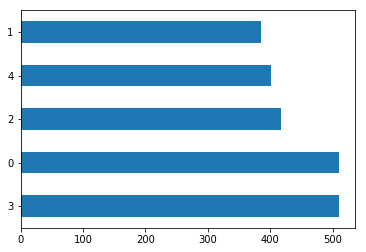

In [9]:
pd.Series(y).value_counts().plot(kind = "barh");

In [10]:
le.inverse_transform(np.array([0,1,2,3,4]))

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

## Vectorización

In [11]:
mi_vectorizador = MiVectorizador(stop_words_lem=True,min_df=3)
X = mi_vectorizador.fit_transform(X)

## Dimensionalidad

In [18]:
X.shape

(2225, 9671)

## SOM Algo

In [19]:
som = SOM2D( 5, 5, alpha = 0.05, distance = 2, epochs = 10)
som.compile()
som.fit(X,y)

Iniciando el proceso SOM Algo...
Numero de iteraciones 10
[***---------------------------] | 10.00% : Tiempo:2.66s 	 || 
[******------------------------] | 20.00% : Tiempo:5.33s 	 || 
[*********---------------------] | 30.00% : Tiempo:7.89s 	 || 
[************------------------] | 40.00% : Tiempo:10.38s 	 || 
[***************---------------] | 50.00% : Tiempo:12.87s 	 || 
[******************------------] | 60.00% : Tiempo:15.33s 	 || 
[*********************---------] | 70.00% : Tiempo:17.82s 	 || 
[************************------] | 80.00% : Tiempo:20.32s 	 || 
[***************************---] | 90.00% : Tiempo:22.81s 	 || 
[******************************] | 100.00% : Tiempo:25.30s 	 || 
Total iteraciones para el proceso SOM Algo fue de: 10
Tiempo total: 25.304s
Tiempo medio: 2.530357098579407s


# Mapas

### - Distancia

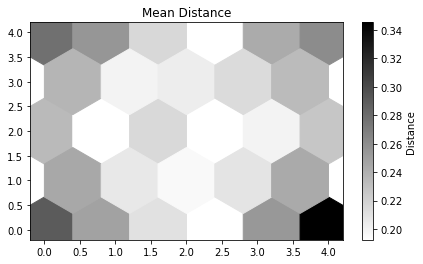

In [28]:
som.plot()

## - Etiquetas

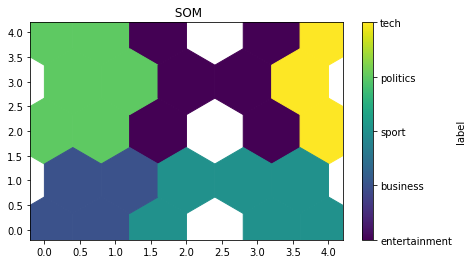

In [29]:
labels = le.inverse_transform([0,1,2,3,4])
som.plot(som_map="labeled", ticklabels=labels )

## Medida de Error

### Error de cuantificación

In [23]:
som.quantization_error

0.9604065396310214

### Error Topológico

In [24]:
som.topological_error

0.06157303370786517